In [1]:
import matplotlib.pyplot as plt
from LIMxCMBL.toy import *

/sdf/group/kipac/users/delon/miniconda3/lib/python3.12/site-packages/pyccl/pk2d.py:285: RuntimeWarning: divide by zero encountered in log
  lk_use = np.log(k_use)
100%|██████████| 50/50 [00:00<00:00, 165.88it/s]


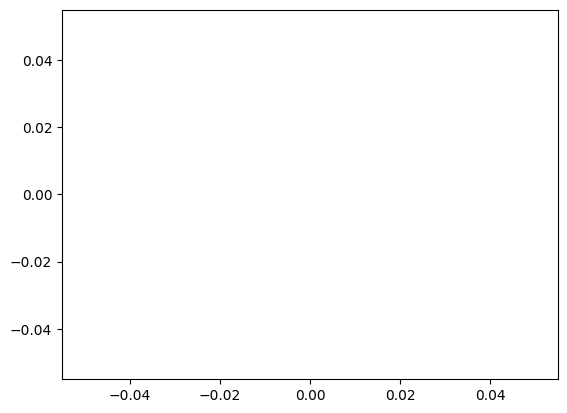

In [2]:
plt.plot()
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 10,
    "font.family" : "serif",
    'figure.constrained_layout.use':True,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'hatch.linewidth':0.1,
    'figure.figsize': (6, 6/1.618),
    'figure.constrained_layout.use': True,
    'axes.labelsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
})

# analyze Monte Carlo results

## load all the sims

In [3]:
import os

pkl_files = []
for file in os.listdir('/sdf/scratch/kipac/delon/toy_model_LIMxCMBL/'):
    if file.endswith('.pkl'):
        pkl_files.append(file)

pkl_files = sorted(pkl_files)

In [18]:
pkl_files_only_Ik = []
for file in os.listdir('/sdf/scratch/kipac/delon/toy_model_LIMxCMBL/OLD'):
    if file.endswith('.pkl'):
        pkl_files_only_Ik.append(file)

pkl_files_only_Ik = sorted(pkl_files_only_Ik)

In [34]:
n_runs = 0
measured_spectra = {}

process = {
        'kk':     [1],
        'LC_Ik' : [(n_k_bins)],
        'nLC_Ik': [(n_k_bins)],
        'LC_II':  [((n_k_bins), (n_k_bins)), ],
        'nLC_II': [((n_k_bins), (n_k_bins)), ]
}

for _type in process:
    measured_spectra[_type] = np.zeros(process[_type][-1], dtype=np.complex128)
    measured_spectra[_type+'_MSE'] = np.zeros(process[_type][-1])

In [35]:
for pkl_file in tqdm(pkl_files):
    _n_runs = int(pkl_file.split('_')[-1].split('.')[0])
    oup_mc_fname = '/sdf/scratch/kipac/delon/toy_model_LIMxCMBL/monte_carlo_toy_model_nrun_%d.pkl'%(_n_runs)
    with open(oup_mc_fname, 'rb') as f:
        _measured_spectra = pickle.load(f)
        
    for _type in measured_spectra:
        measured_spectra[_type] += _measured_spectra[_type]
    n_runs += _n_runs
    print('tot nrun', n_runs)

for _type in process:
    measured_spectra['estimated_'+_type] = measured_spectra[_type]/n_runs
    measured_spectra['estimated_'+_type+'_MSE'] = measured_spectra[_type+'_MSE']/n_runs/(n_runs - 1)

100%|██████████| 4/4 [00:00<00:00, 350.53it/s]

tot nrun 2
tot nrun 2888
tot nrun 5775
tot nrun 6287


In [36]:
#my old MC's were doing the I_kappa right but not I conj(I)...

for pkl_file in tqdm(pkl_files_only_Ik): 
    _n_runs = int(pkl_file.split('_')[-1].split('.')[0])
    oup_mc_fname = '/sdf/scratch/kipac/delon/toy_model_LIMxCMBL/OLD/monte_carlo_toy_model_nrun_%d.pkl'%(_n_runs)
    with open(oup_mc_fname, 'rb') as f:
        _measured_spectra = pickle.load(f)
        
    for _type in measured_spectra:
        if('estimated' in _type):
            continue
        measured_spectra[_type] += _measured_spectra[_type]
    n_runs += _n_runs
    print('tot nrun', n_runs)

for _type in ['kk', 'LC_Ik', 'nLC_Ik']: 
    measured_spectra['estimated_'+_type] = measured_spectra[_type]/n_runs
    measured_spectra['estimated_'+_type+'_MSE'] = measured_spectra[_type+'_MSE']/n_runs/(n_runs - 1)

100%|██████████| 9/9 [00:00<00:00, 418.61it/s]

tot nrun 57521
tot nrun 7617523
tot nrun 15177526
tot nrun 22737530
tot nrun 30297535
tot nrun 37857541
tot nrun 45417548
tot nrun 52977556
tot nrun 60537565


## projected quantities

In [37]:
print((measured_spectra['estimated_kk'] - expected_kappa2)/expected_kappa2)
print(jnp.sqrt(measured_spectra['estimated_kk_MSE'])/measured_spectra['estimated_kk'])

[0.00012467+0.j]
[0.00018171+0.j]


## LIM Lensing cross 3D x 2D

In [45]:
for _type in ['LC', 'nLC']:
    _estimated_II = measured_spectra['estimated_'+_type+'_II']
    _estimated_Ik = measured_spectra['estimated_'+_type+'_Ik']
    _estimated_cov = estimated_kk * _estimated_II + _estimated_Ik.reshape(-1, 1) * jnp.conj(_estimated_Ik.reshape(1, -1))
    measured_spectra['estimated_'+_type+'_cov'] = _estimated_cov

Text(0, 0.5, '$|\\langle I(k)\\kappa\\rangle|$')

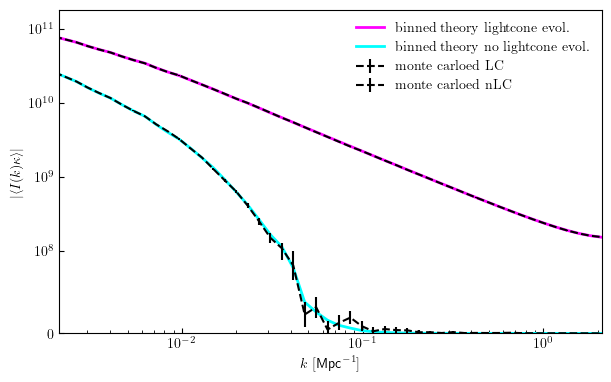

In [46]:
plt.plot(k_bin_centers, jnp.abs(binned_Ik_kappa), label='binned theory lightcone evol.', c='magenta', lw=2)
plt.plot(k_bin_centers, jnp.abs(binned_Ik_kappa_noLC), label='binned theory no lightcone evol.', c='cyan', lw=2)


color = {'LC': 'k', 'nLC':'k'}
for _type in ['LC', 'nLC']:
    curr_spectra = jnp.abs(measured_spectra['estimated_'+_type+'_Ik'])
    binned_rmse = jnp.sqrt(measured_spectra['estimated_'+_type+'_Ik_MSE'])
    plt.errorbar(k_bin_centers, curr_spectra, yerr=jnp.real(binned_rmse),
                 label='monte carloed %s'%_type, ls='--', c=color[_type])

plt.legend(frameon=False)

plt.yscale('symlog', linthresh=1e8)
plt.ylim(0, None)

# plt.xscale('symlog', linthresh=1e-3)
plt.xscale('log')
plt.xlim(k_bin_centers[1], k_bin_centers[-1])

plt.xlabel(r'$k$ [${\sf Mpc}^{-1}$]')
plt.ylabel(r'$|\langle I(k)\kappa\rangle|$')

# compute monte carlo estiamtd SNR
a subtly, I am averaging MC sims and then binning in $k$ as opposed to binning each MC sim and then averaging the binned quantities so what I am doing is not exactly correct. indeed when I compute the SNR it is minorly biased if I (average then bin) as opposed to the true unbiased (bin then average). so for the SNR curve, I plot the SNR computed with unbinned quantities. for the spectrum <I(k) kappa>, for visualization I am showing what I get if I (average than bin) currently.

In [47]:
SNR2s = {'LC':np.zeros(n_k_bins), 'nLC': np.zeros(n_k_bins),
         'LC_MSE':np.zeros(n_k_bins), 'nLC_MSE': np.zeros(n_k_bins),
         'theoryLC':np.zeros(n_k_bins), 'theorynLC': np.zeros(n_k_bins),}

In [48]:
theory_covs = {'LC': expected_binned_cov, 'nLC': expected_binned_cov_noLC}
theory_Ik = {'LC': binned_Ik_kappa, 'nLC': binned_Ik_kappa_noLC}

In [49]:
@jax.jit
def get_MSE_of_SNR2(
    Ik,
    II,
    Ik_MSE,
    II_MSE
):
    II_flat = II.reshape(-1)
    
    def compute_snr2_flat_II(Ik, II_flat, kk):
        II = II_flat.reshape(len(Ik), len(Ik))
        cov = kk * II + Ik.reshape(-1, 1) * jnp.conj(Ik.reshape(1, -1))
        x_sol, _, _, _ = jnp.linalg.lstsq(cov, jnp.conj(Ik))
        return jnp.real(Ik @ x_sol)

    grad_II_flat = jax.jacrev(compute_snr2_flat_II, argnums=1)(Ik, II_flat, estimated_kk)
    grad_II = grad_II_flat.reshape(II.shape)

    grad_Ik = jax.jacrev(compute_snr2_flat_II, argnums=0)(Ik, II_flat, estimated_kk)
    grad_kk = jax.jacrev(compute_snr2_flat_II, argnums=2)(Ik, II_flat, estimated_kk)

    ret = estimated_kk_MSE * grad_kk**2  + jnp.sum((grad_Ik)*jnp.conj(grad_Ik) * Ik_MSE) + jnp.sum((grad_II)*jnp.conj(grad_II).T * II_MSE)    
    return ret

In [51]:
for _type in ['LC', 'nLC']:
    for kill_idx in trange(n_k_bins):
        #throw out k <= k_bin_edge[kill_idx]
        x,resid,rank,s = jnp.linalg.lstsq(measured_spectra['estimated_'+_type+'_cov'][kill_idx:, kill_idx:], 
                                          jnp.conj(measured_spectra['estimated_'+_type+'_Ik'][kill_idx:]))
        
        SNR2s[_type][kill_idx] = jnp.real(measured_spectra['estimated_'+_type+'_Ik'][kill_idx:] @ x)
        
        SNR2s[_type+'_MSE'][kill_idx] = jnp.real(get_MSE_of_SNR2(
            (measured_spectra['estimated_'+_type+'_Ik'])[kill_idx:],
            (measured_spectra['estimated_'+_type+'_II'])[kill_idx:, kill_idx:],
            measured_spectra['estimated_'+_type+'_Ik_MSE'][kill_idx:],
            measured_spectra['estimated_'+_type+'_II_MSE'][kill_idx:, kill_idx:]))[0]

        x,resid,rank,s = jnp.linalg.lstsq(theory_covs[_type][kill_idx:, kill_idx:], 
                                          jnp.conj(theory_Ik[_type][kill_idx:]))
        SNR2s['theory'+_type][kill_idx] = jnp.real(theory_Ik[_type][kill_idx:] @ x)

100%|██████████| 49/49 [00:00<00:00, 143.31it/s]


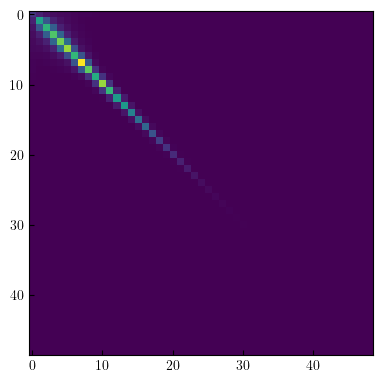

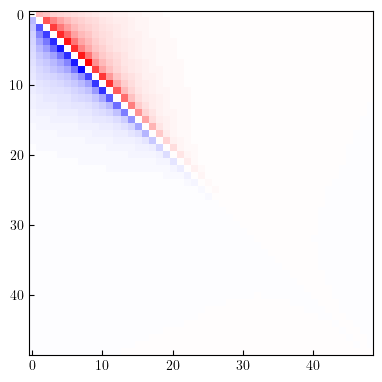

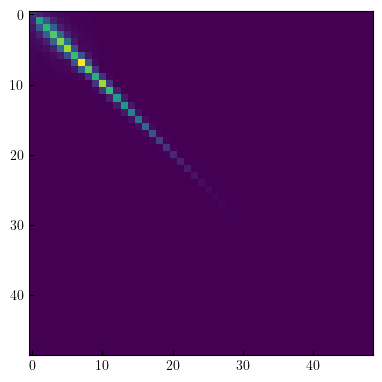

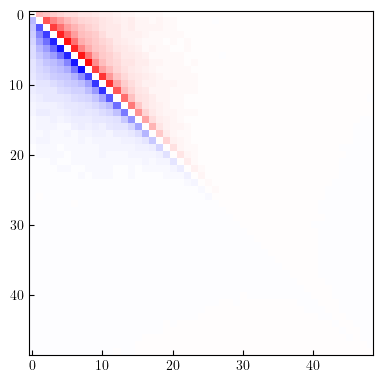

In [52]:
vb = np.max(np.abs(theory_covs['LC']))
plt.imshow(jnp.real(theory_covs['LC']), vmin = 0, vmax=vb, cmap='viridis')
plt.show()
plt.imshow(jnp.imag(theory_covs['LC']), vmin = -vb, vmax=vb, cmap='seismic')
plt.show()
plt.imshow(jnp.real(measured_spectra['estimated_LC_cov']), vmin = 0, vmax=vb, cmap='viridis')
plt.show()
plt.imshow(jnp.imag(measured_spectra['estimated_LC_cov']), vmin = -vb, vmax=vb, cmap='seismic')
plt.show()

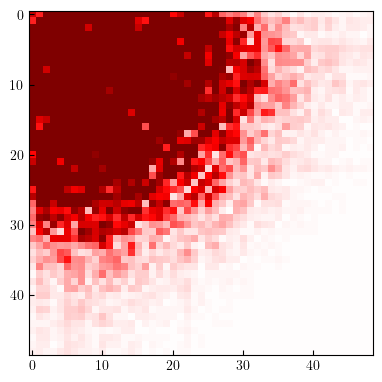

In [53]:
plt.imshow(jnp.abs(theory_covs['LC'] - measured_spectra['estimated_LC_cov']), vmin = -vb/1000, vmax=vb/1000, cmap='seismic')
plt.show()

In [54]:
LC_k = 'magenta'
nLC_color = 'cyan'
nLC_lw = 3
color = {'LC': 'k', 'nLC':'k'}

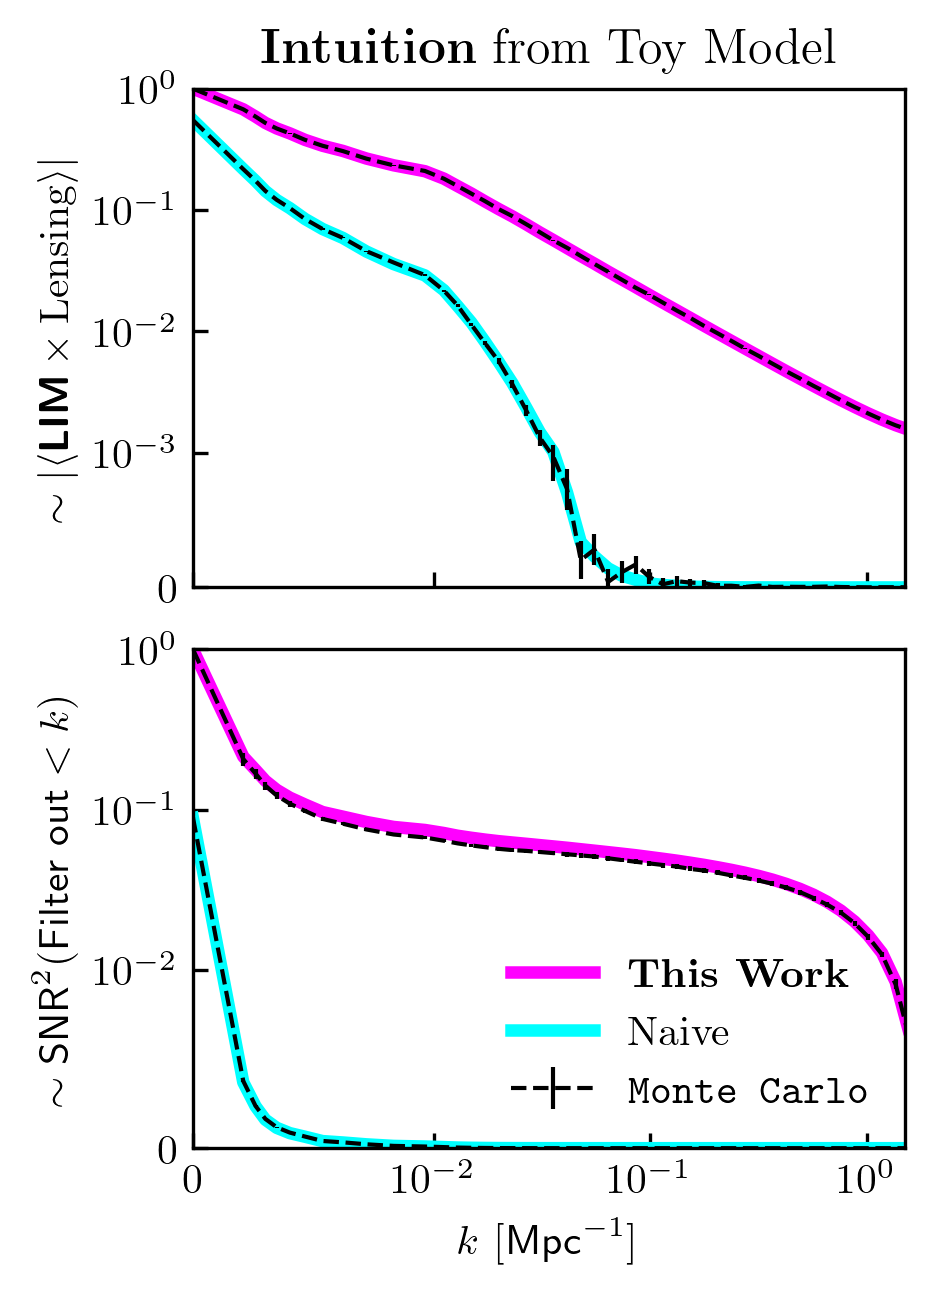

In [58]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(3,4.2), dpi=300)

axs[0].set_title(r'\textbf{Intuition} from Toy Model')

# <Ik> plot
def _plot(x, y, **params):
    axs[0].plot(x, jnp.abs(y/binned_Ik_kappa[0]), **params)
    # axs[0].scatter(x, jnp.abs(y/binned_Ik_kappa[0]))
    
_plot(k_bin_centers, binned_Ik_kappa, 
         label=r'\textbf{This Work}', c=LC_k, lw=3)

_plot(k_bin_centers, binned_Ik_kappa_noLC, 
         label='Naive', c=nLC_color, lw=nLC_lw, ls='-')

for _type in ['LC', 'nLC']:
    curr_spectra = jnp.abs(measured_spectra['estimated_'+_type+'_Ik'])
    binned_rmse = jnp.sqrt(measured_spectra['estimated_'+_type+'_Ik_MSE'])
    
    # # LC has basically no error bars but weird visual artifacts from a 1/10000 error that are distracting
    # # so for plotting purposes I think its better to set their error to zero
    # if(_type == 'LC'):
    #     binned_rmse = jnp.zeros_like(binned_rmse)
        
    axs[0].errorbar(k_bin_centers, curr_spectra/np.abs(binned_Ik_kappa)[0], 
                    yerr=jnp.abs(binned_rmse)/np.abs(binned_Ik_kappa)[0], 
                    lw=1,
                    ls='--', c=color[_type])



axs[0].plot([-100, -99, ], [-1000000, -1000000], c='k', ls='--', label=r'\texttt{Monte Carlo}')

axs[0].set_yscale('symlog', linthresh=1e-3)
axs[0].set_ylim(0, 1)

axs[0].set_ylabel(r'$\sim |\langle \textbf{\textsf{LIM}}\times \rm{Lensing}\rangle|$')
# axs[0].set_xlabel(r'$k$ [${\sf Mpc}^{-1}$]')



# SNR2 Plot
def _plot(x, y, **params):
    axs[1].plot(x, y/SNR2s['theoryLC'][0], **params)

_plot(k_bin_centers, SNR2s['theoryLC'], c=LC_k, lw=3, label=r'\textbf{This Work}')
_plot(k_bin_centers, SNR2s['theorynLC'], c=nLC_color, lw=nLC_lw, label='Naive')

for _type in ['LC', 'nLC']:
    # _plot(k_bin_centers, SNR2s[_type], c=color[_type], lw=1, ls='--')
    axs[1].errorbar(k_bin_centers, (SNR2s[_type]/SNR2s['theoryLC'][0]),
                        yerr=(jnp.sqrt(SNR2s[_type+'_MSE'])/SNR2s['theoryLC'][0]),
                        lw=1,
                        ls='--', c=color[_type])
    
# _plot(Lambdas, SNR2s_proj, c='lightgrey', lw=1)
# _plot(Lambdas, jnp.real(estimated_Ik_proj**2/estimated_var_proj), 
#          c='yellow', lw=1, ls='--')

axs[1].errorbar([0, 100], [100, 100], yerr=0, lw=1, c='k', ls='--', label=r'\texttt{Monte Carlo}')


# axs[1].set_yscale('log')
# axs[1].set_ylim(1e-6,2e0)
axs[1].set_yscale('symlog', linthresh=1e-2)
axs[1].set_ylim(0, 1e0)


axs[1].set_ylabel(r'$\sim {\sf SNR}^2(\textsf{Filter out}<k)$')
axs[1].set_xlabel(r'$k$ [${\sf Mpc}^{-1}$]')

plt.xscale('symlog', linthresh=1e-2)#np.array(k_bin_edges[1]))
plt.xlim(0, 1.5)

# axs[0].legend(frameon=False)
axs[1].legend(frameon=False, loc='lower right')

plt.savefig('figures/015.003.pdf', bbox_inches = 'tight')